<h1 style="text-align: center; font-size: 3rem;">A geophysical tour of mid-ocean ridges</h1>
<p style="text-align: center; color: #666; font-size: 1.5rem;">A tutorial for <a href="https://transform.softwareunderground.org/">Transform 2022</a></p>
<img src="https://github.com/compgeolab/transform2022/raw/main/figures/transform-logo.png" alt="Transform2022 logo" style="max-width: 600px; margin: 0 auto 2rem auto; display: block">
<p style="text-align: center; color: #666; font-size: 1rem; margin-bottom: 2rem;"><strong>Instructor:</strong> <a href="https://www.leouieda.com">Leonardo Uieda</a> - University of Liverpool, UK</p>
<p style="text-align: center;"><span style="margin-right: 5px; font-size: 20px"> </span> <a href="https://github.com/compgeolab/transform2022"><code>compgeolab/transform2022</code></a></p>
<p style="text-align: center;"><span style="margin-right: 5px; font-size: 20px"> </span> <a href="https://www.youtube.com/watch?v=NzJmRlJCNbQ"><code>youtube.com/watch?v=NzJmRlJCNbQ</code></a></p>
<p style="text-align: center;"><span style="margin-right: 10px; font-size: 20px"> </span> Text and figures licensed <a href="https://creativecommons.org/licenses/by/4.0/">CC-BY</a></p>
<p style="text-align: center;"><span style="margin-right: 10px; font-size: 20px"> </span> Python code licensed <a href="https://github.com/compgeolab/transform2022/blob/main/LICENSE.txt">BSD 3-clause</a></p>

---

## ℹ️ About this tutorial

Mid-ocean ridges are the places where the oceanic crust and lithosphere are born. They are large mountain ranges in the deep ocean, stretching all around the globe and with heights rivalling that of the tallest mountains on land. Ridges are also a key part of plate tectonics, a major component of the biogeochemical cycle of the oceans, and the home of unique biological communities.

In this tutorial, we'll study the **mid-ocean ridges through the lens of geophysics**. We'll use open geophysical data (gravity, bathymetry, lithospheric age) and open-source Python tools to try to answer questions like: 

* How do ridges stay so tall? 
* Are they in isostatic equilibrium? 
* Why do ocean basins get deeper as they age? 

Along the way, we'll also learn how to translate into code the physical models of the cooling of the lithosphere so that we can compare their predictions with our data.

> **Note:** This tutorial was inspired by a computer-based practical lesson that I developed by the module *ENVS398 Global Geophysics & Geodynamics* of the University of Liverpool. Because of the Transform format, some of the more interactive components that I would do during a live in-person class were removed but there is still room for personal experimentation. 

**Instructions:** See the GitHub repository <i class="fab fa-github"></i> <a href="https://github.com/compgeolab/transform2022"><code>compgeolab/transform2022</code></a> for instructions on computer setup, following the tutorial, asking questions, etc. **I highly encourage everyone to experiment with the code here and explore the data in further detail** after the tutorial content is over.

## 🐍 Import the required libraries

We'll be using several tools from the Scientific Python stack:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import verde as vd
import boule
import pooch
import pygmt

## 📈 To the data!

The data we'll be using in this tutorial are:

* [ETOPO1](https://doi.org/10.5281/zenodo.5882203) (public domain): A global model of topography and bathymetry, [originally at 1 arc-minute resolution](https://doi.org/10.7289/V5C8276M) but we'll use a downsampled version to 10 arc-minutes to avoid long downloads.
* [Gravity](https://doi.org/10.5281/zenodo.5882207) (CC-BY): A global grid of observed gravity in mGal at 10 arc-minute resolution generated from the [EIGEN-6C4 spherical harmonic model](https://doi.org/10.5880/icgem.2015.1).
* [Seafloor (lithosphere) age](https://www.earthbyte.org/category/resources/data-models/seafloor-age/) (CC-BY): A 6 arc-minute grid of global seafloor age by [Seton et al. (2020)](https://doi.org/10.1029/2020GC009214).

### Download the data

We can download all of these grids using [Pooch](https://www.fatiando.org/pooch/) if we know where to find them on the internet.

In [7]:
path_etopo1 = pooch.retrieve(
    url="doi:10.5281/zenodo.5882203/earth-topography-10arcmin.nc",
    known_hash="md5:c43b61322e03669c4313ba3d9a58028d",
    progressbar=True,
)
print(path_etopo1)

100%|█████████████████████████████████████| 2.75M/2.75M [00:00<00:00, 1.31GB/s]

/home/leo/.cache/pooch/d4c3e3d55dcc32ff8eeccded782b8fee-earth-topography-10arcmin.nc


In [8]:
path_gravity = pooch.retrieve(
    url="doi:10.5281/zenodo.5882207/earth-gravity-10arcmin.nc",
    known_hash="md5:56df20e0e67e28ebe4739a2f0357c4a6",
    progressbar=True,
)
print(path_gravity)

100%|█████████████████████████████████████| 2.52M/2.52M [00:00<00:00, 1.42GB/s]

/home/leo/.cache/pooch/aaeeee835e7323a329023c89cf21261d-earth-gravity-10arcmin.nc


In [6]:
path_seafloorage = pooch.retrieve(
    url="https://www.earthbyte.org/webdav/ftp/earthbyte/agegrid/2020/Grids/age.2020.1.GTS2012.6m.nc",
    known_hash=None,
    progressbar=True,
)
print(path_seafloorage)

100%|█████████████████████████████████████| 8.07M/8.07M [00:00<00:00, 4.24GB/s]
SHA256 hash of downloaded file: 3abeed4f6e9bfe9332ac6b5dff4c4f19c8a6374528a185f87e677db8152ba39e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


/home/leo/.cache/pooch/ef2430c04d1e162ad02943f476e3d2ad-age.2020.1.GTS2012.6m.nc


### Load the grids

Now we can load these netCDF grids with [xarray](https://docs.xarray.dev).

In [9]:
etopo1 = xr.load_dataarray(path_etopo1)
etopo1

<xarray.DataArray 'topography' (latitude: 1081, longitude: 2161)>
array([[ 2742.,  2742.,  2742., ...,  2742.,  2742.,  2742.],
       [ 2768.,  2768.,  2768., ...,  2768.,  2768.,  2768.],
       [ 2822.,  2822.,  2821., ...,  2822.,  2822.,  2822.],
       ...,
       [-4243., -4244., -4245., ..., -4242., -4243., -4243.],
       [-4156., -4157., -4157., ..., -4156., -4156., -4156.],
       [-4237., -4237., -4237., ..., -4237., -4237., -4237.]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
Attributes:
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height of ETOPO1 (ice surfac...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    references:      https://doi.org/10.7289/V5C8276M
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    [-10023.   6082.]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

In [11]:
gravity = xr.load_dataarray(path_gravity)
gravity

<xarray.DataArray 'gravity' (latitude: 1081, longitude: 2161)>
array([[980106.5 , 980106.5 , 980106.5 , ..., 980106.5 , 980106.5 ,
        980106.5 ],
       [980108.25, 980108.25, 980108.25, ..., 980108.25, 980108.25,
        980108.25],
       [980108.8 , 980108.8 , 980108.8 , ..., 980108.75, 980108.75,
        980108.8 ],
       ...,
       [980153.8 , 980153.75, 980153.6 , ..., 980153.94, 980153.8 ,
        980153.8 ],
       [980160.44, 980160.44, 980160.44, ..., 980160.44, 980160.44,
        980160.44],
       [980157.5 , 980157.5 , 980157.5 , ..., 980157.5 , 980157.5 ,
        980157.5 ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
    height     (latitude, longitude) float32 1e+04 1e+04 1e+04 ... 1e+04 1e+04
Attributes:
    Conventions:     CF-1.8
    title:           Gravity acceleration (EIGEN-6C4) at a constant geometric...
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    references:      https://doi.org/10.5880/icgem.2015.1
    long_name:       gravity acceleration
    description:     magnitude of the gravity acceleration vector (gravitatio...
    units:           mGal
    actual_range:    [974748.6 980201.9]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

In [12]:
seafloorage = xr.load_dataarray(path_seafloorage)
seafloorage

<xarray.DataArray 'z' (lat: 1801, lon: 3601)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [56.6846  , 56.68604 , 56.687473, ..., 56.681698, 56.68315 ,
        56.6846  ],
       [55.853275, 55.85453 , 55.855785, ..., 55.850758, 55.852016,
        55.853275],
       [55.53386 , 55.53386 , 55.53386 , ..., 55.53386 , 55.53386 ,
        55.53386 ]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat      (lat) float64 -90.0 -89.9 -89.8 -89.7 -89.6 ... 89.7 89.8 89.9 90.0
Attributes:
    long_name:     z
    actual_range:  [9.99999978e-03 3.38683990e+02]

### Plot the grids

Now that we have out grids, we can plot them on maps using [PyGMT](https://www.pygmt.org/).

> **💡 Tip:** You could do the same using [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) and [matplotlib](https://matplotlib.org/) but PyGMT is faster and has better support for map projections. 

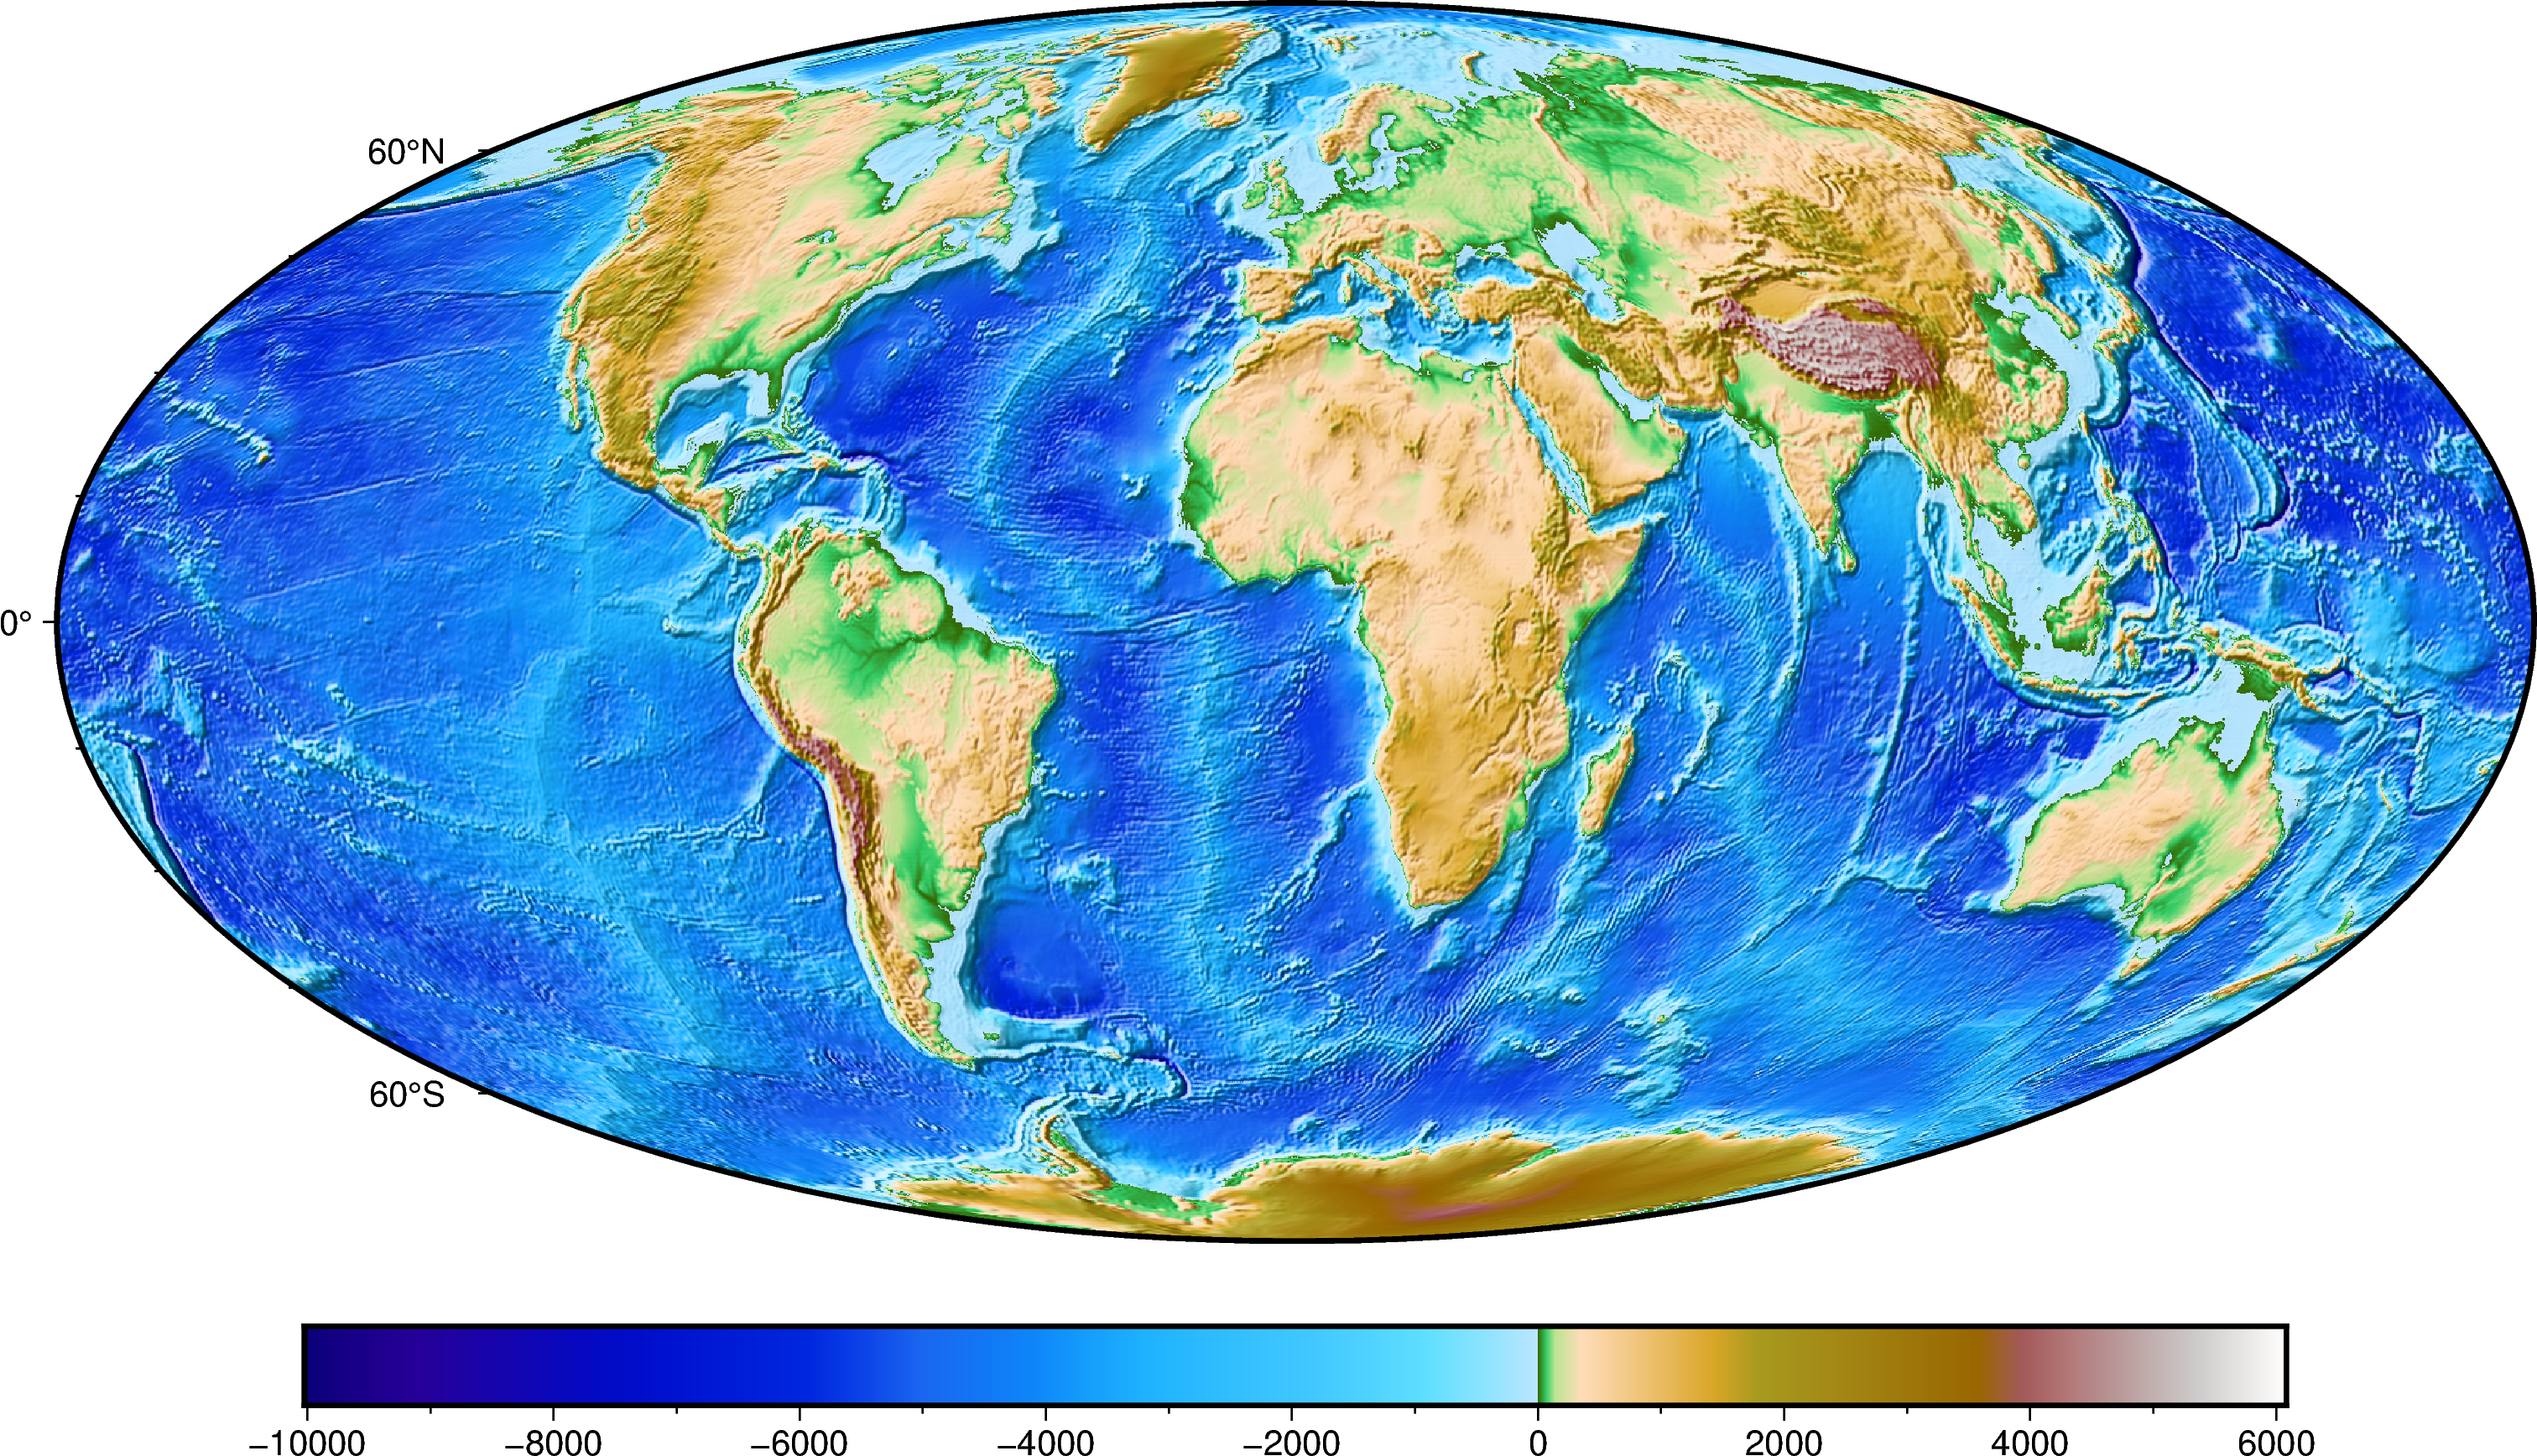

In [14]:
fig = pygmt.Figure()
fig.grdimage(etopo1, cmap="etopo1", shading=True, projection="W25c")
fig.basemap(frame=True)
fig.colorbar()
fig.show(width=800)

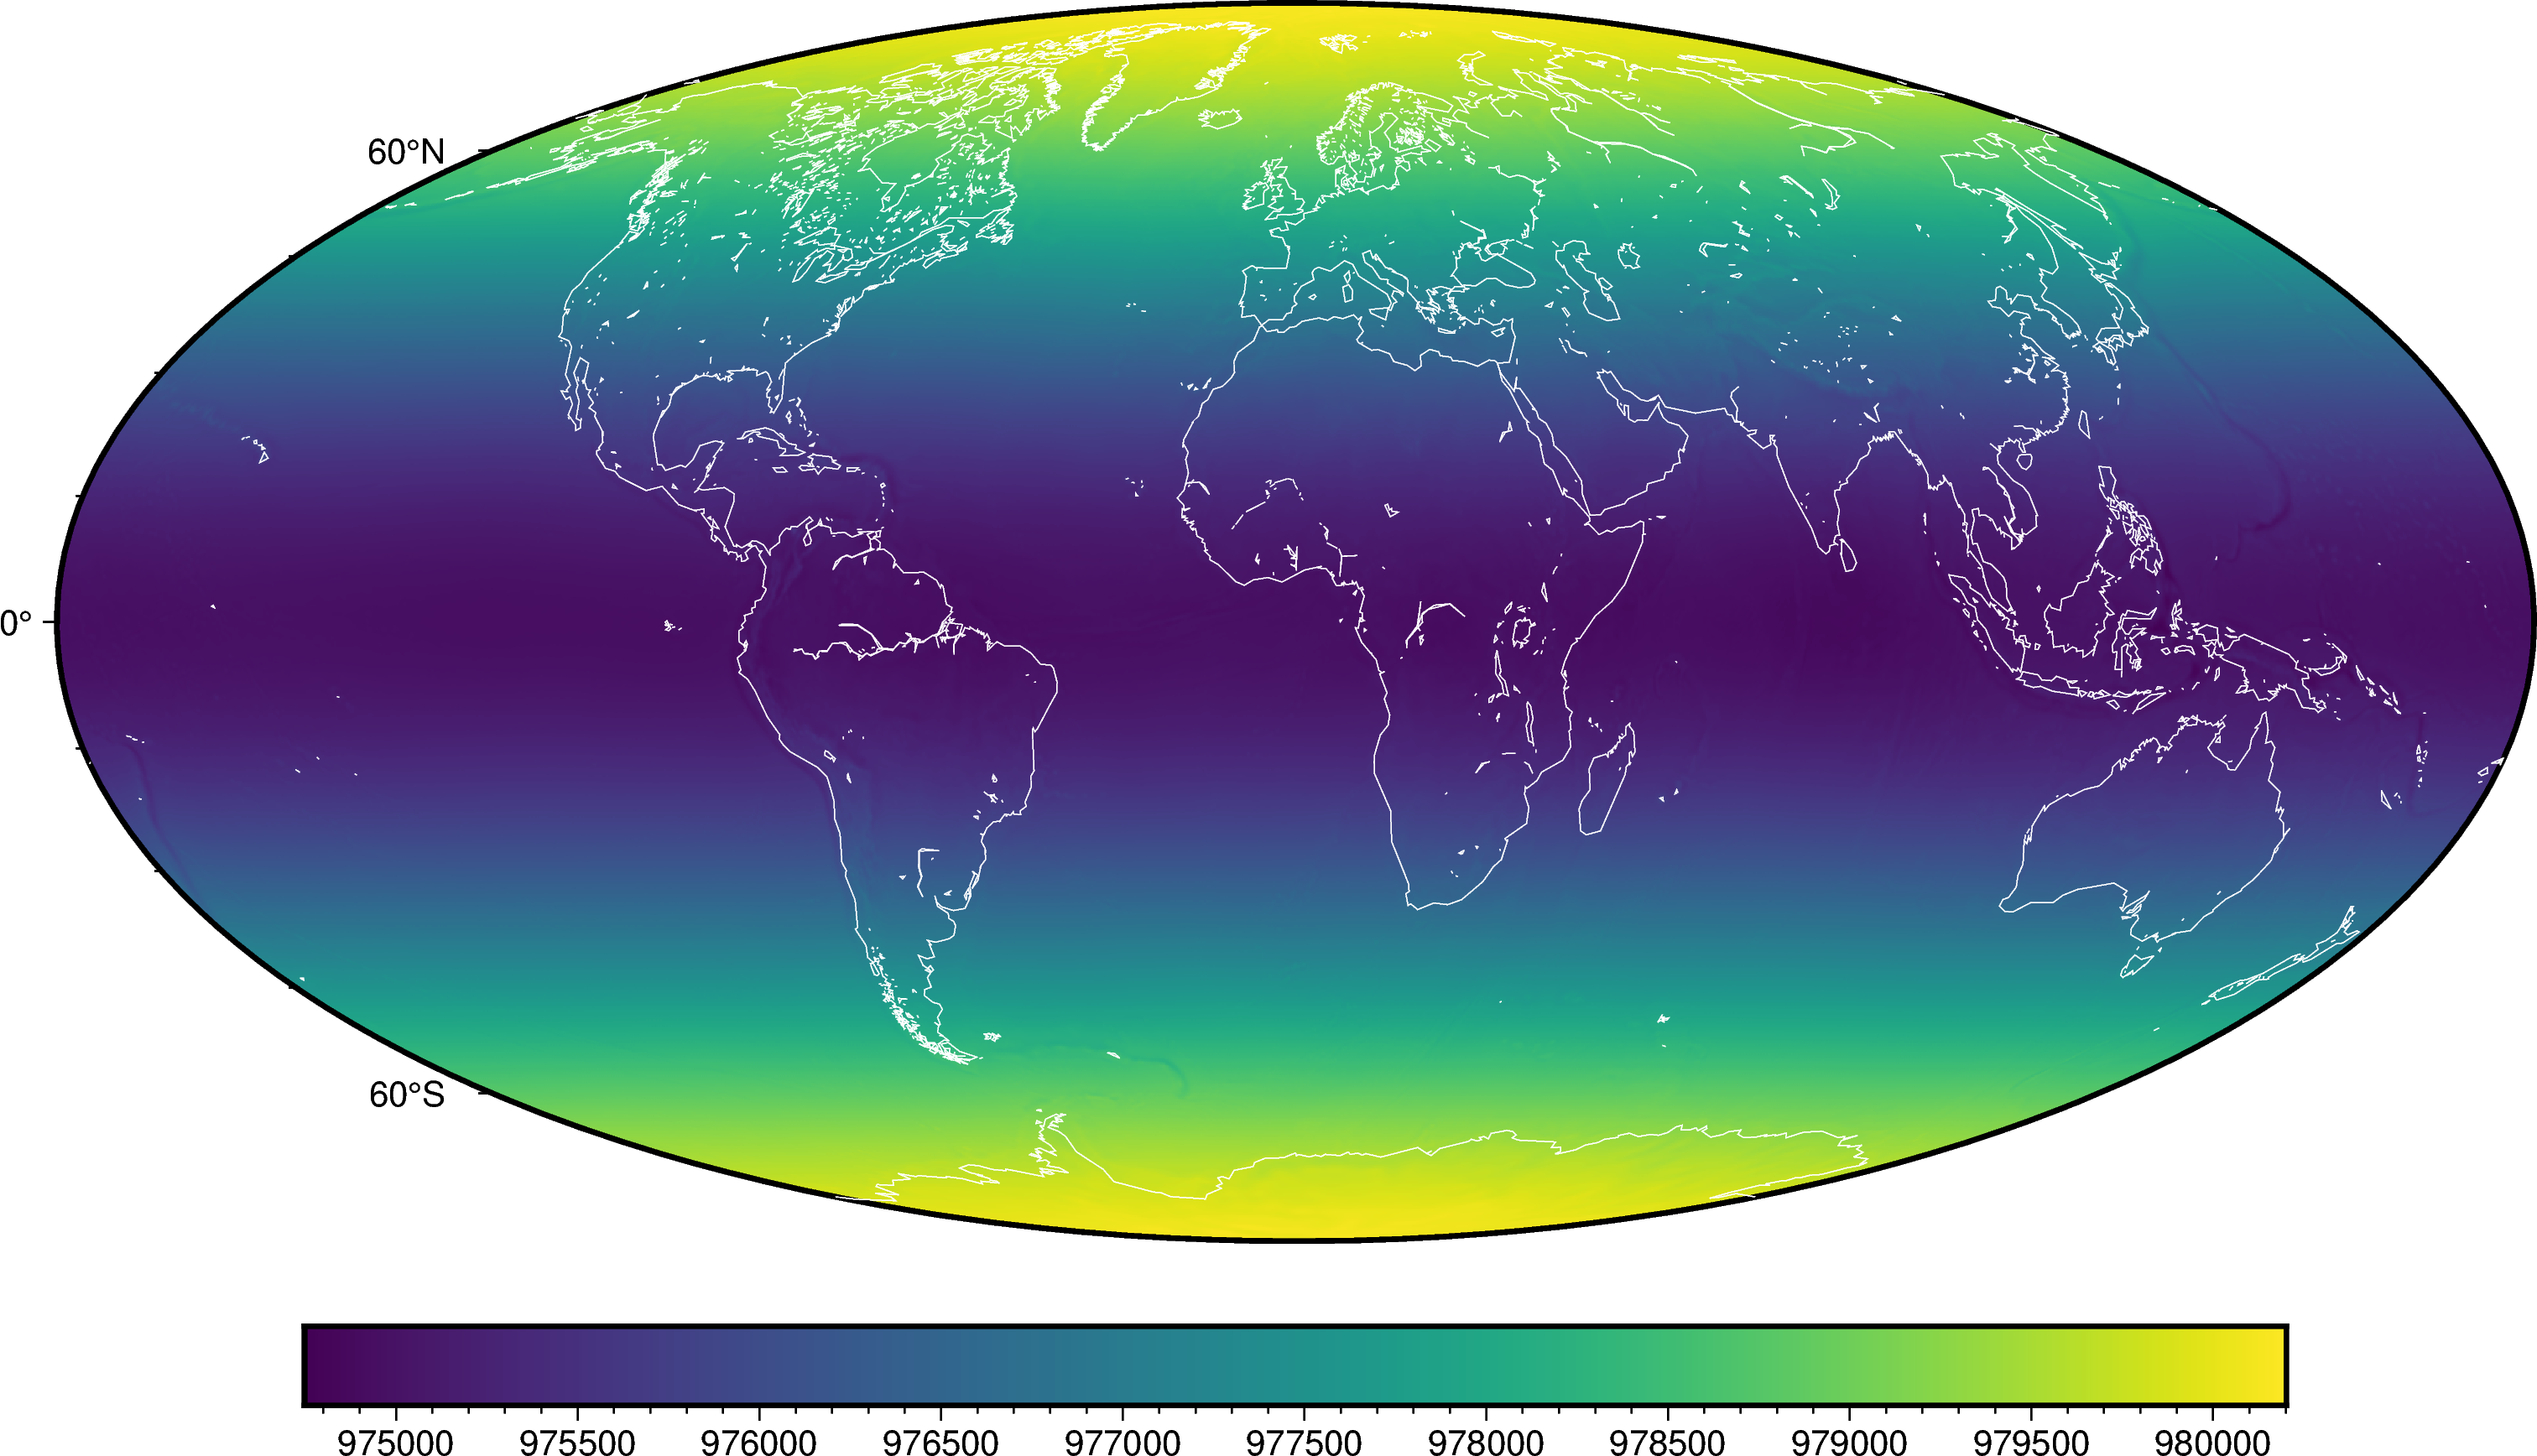

In [18]:
fig = pygmt.Figure()
fig.grdimage(gravity, cmap="viridis", projection="W25c")
fig.basemap(frame=True)
fig.colorbar()
fig.coast(shorelines="white")
fig.show(width=800)

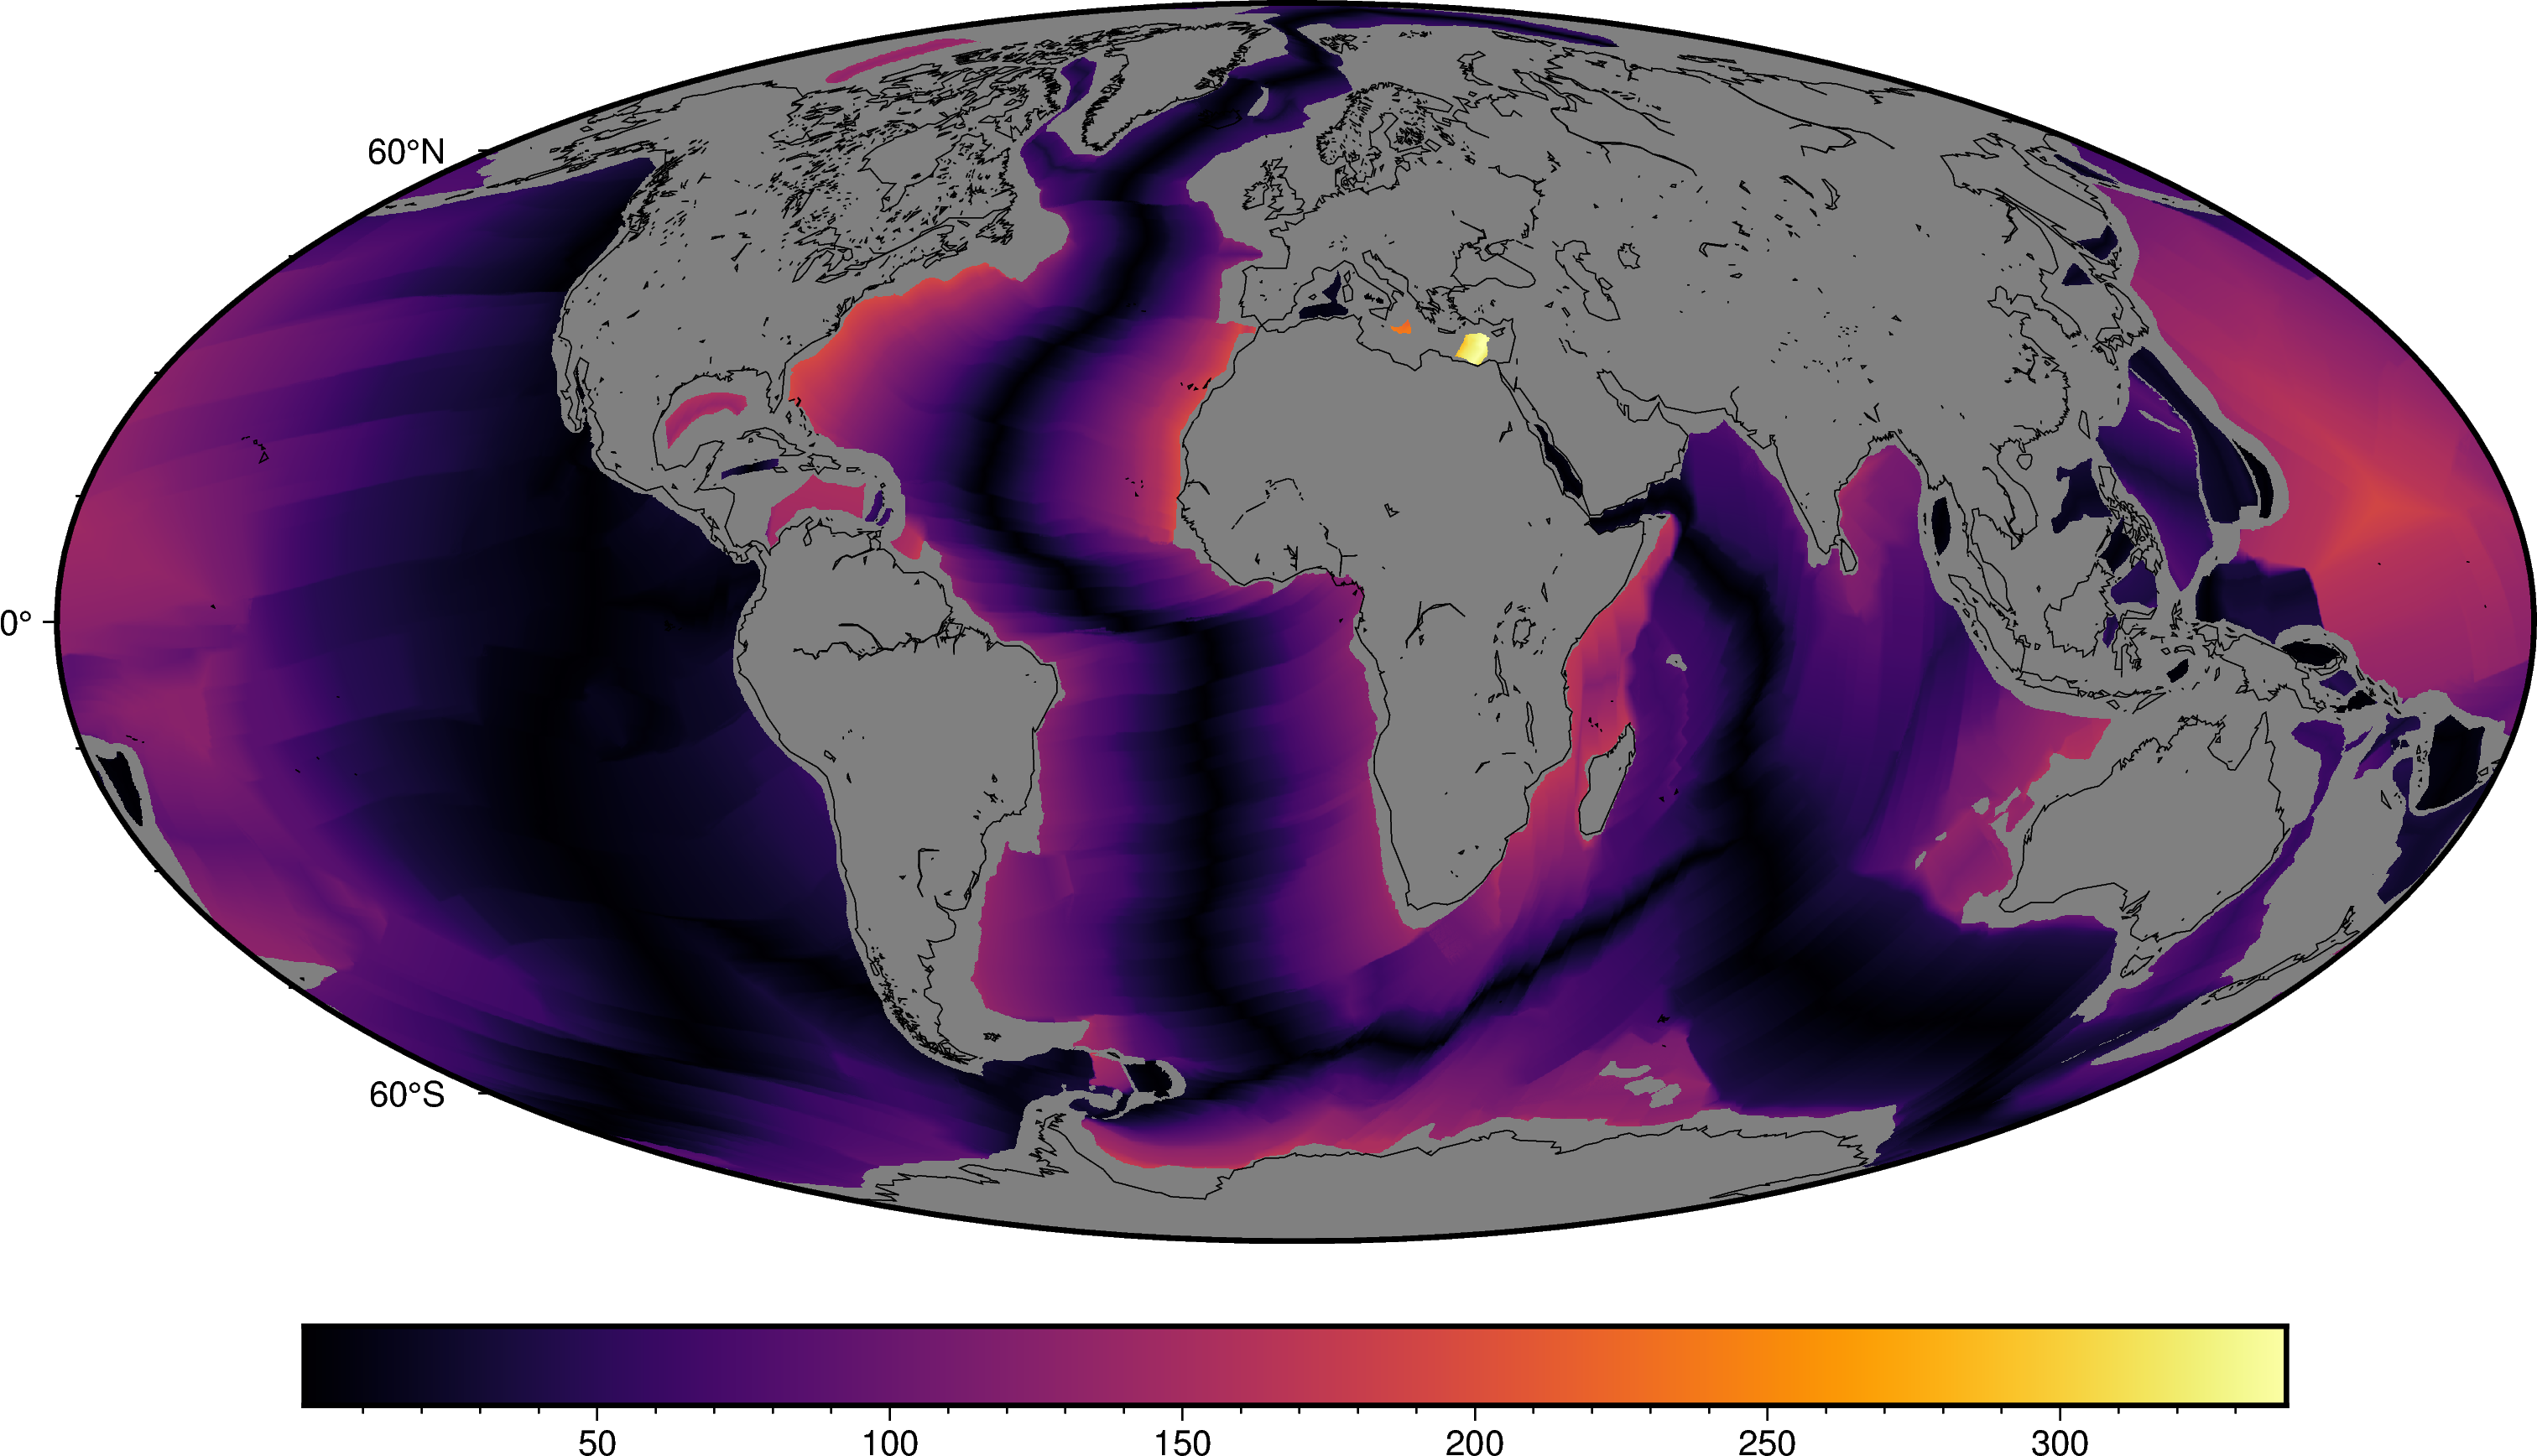

In [20]:
fig = pygmt.Figure()
fig.grdimage(seafloorage, cmap="inferno", projection="W25c")
fig.basemap(frame=True)
fig.colorbar()
fig.coast(shorelines=True)
fig.show(width=800)

## ⛰️ Isostatic state 

Use gravity disturbance to investigate the isostatic state of the lithosphere. Global analysis first looking only at gravity.

## 🔍 Close in on a ridge

Slice the grids to isolate a mid-ocean ridge and plot.

## 💆🏾‍♂️ Prepare the data

Co-register the grids so we can compare. Plot bathymetry vs age. Coarsen and do it again.

## 🍽️ The plate model

Explain the model with a figure and etc. Calculate the temperature of the model.

## 🥠 Predicting bathymetry

Explain the bathymetry prediction for the plate model. Implement and compare against the data.

## 💡 Ideas for you to try

Leave some empty cells and explain ideas of things people can try using the data and model.